# Student Performance

## Данные
Рассмотрим набор данных [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/student+performance): данные об успеваемости учащихся.

Имеется 2 набора данных: математика (395 студентов) и португальский язык (649 студентов), но первый почти полностью лежит во втором, поэтому будем рассматривать только данные об изучающих португальский язык.

Для каждого студента имеется 30 признаков + 3 целевых признака (G1, G2, G3) - оценка по курсу (за первую часть курса, за вторую часть курса и итоговая).

## Задание
Нужно решить задачу предсказания целевого признака G3 итоговой оценки студента по курсу. G3 сильно коррелирует с G1 и G2, поэтому пользоваться этими признаками нельзя. Для оценки качества моделей использовать кросс-валидацию с 10 фолдами, функция потерь - Mean Absolute Error $L(y_{true}, y_{pred}) = \frac{1}{l}\sum_{i=1}^l |y_{true, i} - y_{pred, i}|$. Ваша задача - получить наименьшую ошибку на кросс-валидации, для этого поэкспериментируйте с разными моделями машинного обучения и разными признаковыми описаними объектов. Результаты оформите в виде Jupyter Notebook. Весь код должен без проблем запускаться и отрабатывать. Также оформите некоторые выводы (какие методы Вы использовали, что получилось, какой метод лучший).

Замечения:
1. Для загрузки данных можно использовать pandas, для машинного обучения - sklearn.
2. Для кросс-валидации можно использовать модуль sklearn.model_selection. Для воспроизводимости результатов явно инициализируйте генератор случайных чисел (разберитесь, как).
3. Обратите внимание, что многие признаки в наборе данных - не вещественные, а категориальные (categorical) или порядковые (ordinal). О том, как работать с такими признаками, можно начать читать [здесь](https://dyakonov.org/2016/08/03/python-%d0%ba%d0%b0%d1%82%d0%b5%d0%b3%d0%be%d1%80%d0%b8%d0%b0%d0%bb%d1%8c%d0%bd%d1%8b%d0%b5-%d0%bf%d1%80%d0%b8%d0%b7%d0%bd%d0%b0%d0%ba%d0%b8/).
4. Обратите внимание, что целевой признак - целые числа от 0 до 20.
5. Обратите внимание, что не все алгоритмы обучения способны работать с L1-loss. Но не факт, что их нужно обучать с L1-loss.

In [98]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import LabelEncoder
from IPython.core.pylabtools import figsize
from sklearn import tree
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('student-por.csv', sep=';')

In [3]:
df = df.drop(['G1', 'G2'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
school        649 non-null object
sex           649 non-null object
age           649 non-null int64
address       649 non-null object
famsize       649 non-null object
Pstatus       649 non-null object
Medu          649 non-null int64
Fedu          649 non-null int64
Mjob          649 non-null object
Fjob          649 non-null object
reason        649 non-null object
guardian      649 non-null object
traveltime    649 non-null int64
studytime     649 non-null int64
failures      649 non-null int64
schoolsup     649 non-null object
famsup        649 non-null object
paid          649 non-null object
activities    649 non-null object
nursery       649 non-null object
higher        649 non-null object
internet      649 non-null object
romantic      649 non-null object
famrel        649 non-null int64
freetime      649 non-null int64
goout         649 non-null int64
Dalc          649 no

In [5]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000


In [6]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

def remove_collinear_features(x, threshold):
    y = x['G3']
    x = x.drop(columns = ['G3'])
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            if val >= threshold:
                drop_cols.append(col.values[0])
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x['G3'] = y
    return x

In [36]:
missing_values_table(df)

Your selected dataframe has 31 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


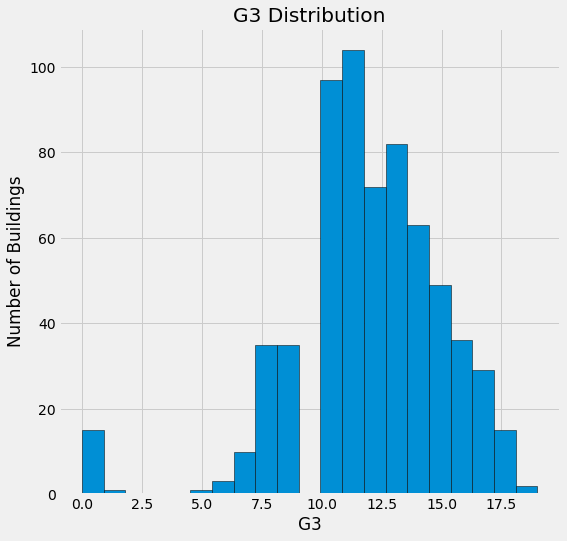

In [8]:
figsize(8, 8)
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(df['G3'].dropna(), bins = 21, edgecolor = 'k');
plt.xlabel('G3'); plt.ylabel('Number of Buildings');
plt.title('G3 Distribution');

In [10]:
correlations_df = df.corr()['G3'].sort_values()
print(correlations_df.head(15))
print(correlations_df.tail(15))

failures     -0.393316
Dalc         -0.204719
Walc         -0.176619
traveltime   -0.127173
freetime     -0.122705
age          -0.106505
health       -0.098851
absences     -0.091379
goout        -0.087641
famrel        0.063361
Fedu          0.211800
Medu          0.240151
studytime     0.249789
G3            1.000000
Name: G3, dtype: float64
failures     -0.393316
Dalc         -0.204719
Walc         -0.176619
traveltime   -0.127173
freetime     -0.122705
age          -0.106505
health       -0.098851
absences     -0.091379
goout        -0.087641
famrel        0.063361
Fedu          0.211800
Medu          0.240151
studytime     0.249789
G3            1.000000
Name: G3, dtype: float64


In [31]:
cat = ['Medu', 'Fedu', 'traveltime', 'studytime', 'school', 'sex',
       'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason',
       'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic']

In [38]:
features = df.copy()
numeric_subset = df.select_dtypes('number')
for c in numeric_subset.columns:
    if c == 'G3':
        next
    else:
        numeric_subset['log_' + c] = np.log(numeric_subset[c])
categorical_subset = features[cat]
categorical_subset = pd.get_dummies(categorical_subset)
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features.shape

/data/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/data/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(649, 74)

In [39]:
categorical_subset = pd.get_dummies(cat)
categorical_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 21 columns):
Fedu          21 non-null uint8
Fjob          21 non-null uint8
Medu          21 non-null uint8
Mjob          21 non-null uint8
Pstatus       21 non-null uint8
activities    21 non-null uint8
address       21 non-null uint8
famsize       21 non-null uint8
famsup        21 non-null uint8
guardian      21 non-null uint8
higher        21 non-null uint8
internet      21 non-null uint8
nursery       21 non-null uint8
paid          21 non-null uint8
reason        21 non-null uint8
romantic      21 non-null uint8
school        21 non-null uint8
schoolsup     21 non-null uint8
sex           21 non-null uint8
studytime     21 non-null uint8
traveltime    21 non-null uint8
dtypes: uint8(21)
memory usage: 513.0 bytes


In [40]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 74 columns):
age                  649 non-null int64
Medu                 649 non-null int64
Fedu                 649 non-null int64
traveltime           649 non-null int64
studytime            649 non-null int64
failures             649 non-null int64
famrel               649 non-null int64
freetime             649 non-null int64
goout                649 non-null int64
Dalc                 649 non-null int64
Walc                 649 non-null int64
health               649 non-null int64
absences             649 non-null int64
G3                   649 non-null int64
log_age              649 non-null float64
log_Medu             649 non-null float64
log_Fedu             649 non-null float64
log_traveltime       649 non-null float64
log_studytime        649 non-null float64
log_failures         649 non-null float64
log_famrel           649 non-null float64
log_freetime         649 non-null float64

In [41]:
features = remove_collinear_features(features, 0.6);

In [42]:
features  = features.dropna(axis=1, how = 'all')
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 53 columns):
age                  649 non-null int64
failures             649 non-null int64
famrel               649 non-null int64
freetime             649 non-null int64
goout                649 non-null int64
Dalc                 649 non-null int64
Walc                 649 non-null int64
health               649 non-null int64
absences             649 non-null int64
school_GP            649 non-null uint8
school_MS            649 non-null uint8
sex_F                649 non-null uint8
sex_M                649 non-null uint8
address_R            649 non-null uint8
address_U            649 non-null uint8
famsize_GT3          649 non-null uint8
famsize_LE3          649 non-null uint8
Pstatus_A            649 non-null uint8
Pstatus_T            649 non-null uint8
Mjob_at_home         649 non-null uint8
Mjob_health          649 non-null uint8
Mjob_other           649 non-null uint8
Mjob_services  

In [43]:
correlations_features = features.corr()['G3'].sort_values()
print(correlations_features.head(15))
print(correlations_features.tail(15))

failures        -0.393316
higher_no       -0.332172
school_MS       -0.284294
Dalc            -0.204719
Walc            -0.176619
address_R       -0.167637
internet_no     -0.150025
Mjob_at_home    -0.136778
reason_other    -0.132577
sex_M           -0.129077
freetime        -0.122705
age             -0.106505
health          -0.098851
reason_course   -0.098305
absences        -0.091379
Name: G3, dtype: float64
famsup_yes           0.059206
activities_yes       0.059791
famrel               0.063361
schoolsup_no         0.066405
romantic_no          0.090583
Mjob_health          0.101244
Fjob_teacher         0.125916
sex_F                0.129077
Mjob_teacher         0.134910
internet_yes         0.150025
address_U            0.167637
reason_reputation    0.170944
school_GP            0.284294
higher_yes           0.332172
G3                   1.000000
Name: G3, dtype: float64


In [44]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 53 columns):
age                  649 non-null int64
failures             649 non-null int64
famrel               649 non-null int64
freetime             649 non-null int64
goout                649 non-null int64
Dalc                 649 non-null int64
Walc                 649 non-null int64
health               649 non-null int64
absences             649 non-null int64
school_GP            649 non-null uint8
school_MS            649 non-null uint8
sex_F                649 non-null uint8
sex_M                649 non-null uint8
address_R            649 non-null uint8
address_U            649 non-null uint8
famsize_GT3          649 non-null uint8
famsize_LE3          649 non-null uint8
Pstatus_A            649 non-null uint8
Pstatus_T            649 non-null uint8
Mjob_at_home         649 non-null uint8
Mjob_health          649 non-null uint8
Mjob_other           649 non-null uint8
Mjob_services  

In [45]:
X = features.drop(['G3'], axis=1)

In [46]:
Y = features['G3']

In [136]:
models = [{'model':Ridge(random_state=123890), 'param_grid':0},
          {'model':SGDRegressor(loss='huber', random_state=123890), 'param_grid':0},
          {'model':Lasso(random_state=123890), 'param_grid':0},
          {'model':ElasticNet(random_state=123890), 'param_grid':0},
          {'model':tree.DecisionTreeRegressor(random_state=123890, criterion='mae'), 'param_grid':1},
          {'model':SVR(), 'param_grid':2},
          {'model':KNeighborsRegressor(metric='manhattan'), 'param_grid':3},
          {'model':CatBoostRegressor(loss_function='MAE', random_state=123890), 'param_grid':4}]

scorer = make_scorer(mean_absolute_error)
p_g = [{'alpha': np.arange(0.0001, 1, 0.001)},
       {'max_depth':np.arange(1, 6)},
       {'kernel': ['rbf', 'linear', 'poly'], 'C': np.arange(1, 100)},
       {'n_neighbors':np.arange(1, 10)},
       {'l2_leaf_reg':np.arange(0.5, 1.5, 0.05), 'depth':np.arange(6, 9, 1)}
      ]

In [137]:
res = {model['model'].__class__.__name__: 0 for model in models}
for model in models:
    gr = GridSearchCV(estimator=model['model'], param_grid=p_g[model['param_grid']],
                  n_jobs=-1, verbose=1, cv=10, scoring=scorer, return_train_score=True
             )
    gr.fit(X, Y)
    res[model['model'].__class__.__name__] = {'best':gr.best_score_, 'params':gr.best_params_}

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 2236 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 4636 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 6136 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 7836 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   28.9s finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4540 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 7240 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   24.6s finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6936 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 9536 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   22.6s finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3938 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 5938 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 7088 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 8338 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 9688 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   46.8s finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The d

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 297 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1318 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1868 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2518 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed: 11.7min finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.0s finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.3min finished
/data/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0:	learn: 11.8933140	total: 6.26ms	remaining: 6.25s
1:	learn: 11.8799179	total: 43.7ms	remaining: 21.8s
2:	learn: 11.8666108	total: 51.9ms	remaining: 17.2s
3:	learn: 11.8542432	total: 68.1ms	remaining: 17s
4:	learn: 11.8412944	total: 94.9ms	remaining: 18.9s
5:	learn: 11.8286579	total: 148ms	remaining: 24.5s
6:	learn: 11.8160424	total: 163ms	remaining: 23.2s
7:	learn: 11.8029992	total: 192ms	remaining: 23.8s
8:	learn: 11.7897822	total: 235ms	remaining: 25.9s
9:	learn: 11.7766867	total: 271ms	remaining: 26.9s
10:	learn: 11.7636549	total: 326ms	remaining: 29.4s
11:	learn: 11.7501255	total: 334ms	remaining: 27.5s
12:	learn: 11.7368954	total: 340ms	remaining: 25.8s
13:	learn: 11.7238841	total: 392ms	remaining: 27.6s
14:	learn: 11.7104860	total: 397ms	remaining: 26.1s
15:	learn: 11.6972648	total: 405ms	remaining: 24.9s
16:	learn: 11.6838305	total: 418ms	remaining: 24.2s
17:	learn: 11.6706977	total: 433ms	remaining: 23.6s
18:	learn: 11.6573836	total: 440ms	remaining: 22.7s
19:	learn: 11.64391

In [138]:
pd.DataFrame(res).T.sort_values(['best'])

,best,params
Ridge,2.04808,{u'alpha': 0.0001}
CatBoostRegressor,2.22156,"{u'l2_leaf_reg': 1.1000000000000005, u'depth': 8}"
DecisionTreeRegressor,2.27042,{u'max_depth': 1}
ElasticNet,2.36766,{u'alpha': 0.9991}
Lasso,2.44106,{u'alpha': 0.9991}
SGDRegressor,2.8384,{u'alpha': 0.9991}
KNeighborsRegressor,2.98767,{u'n_neighbors': 1}
SVR,3.92739,"{u'kernel': u'poly', u'C': 99}"
